# Exercise 6b - Advanced segmentation. Fisherman's Linear discrimination analysis for segmentation

## Introduction

The exercise is to the extent of the pixel-wise classification problem from being based on the intensity histogram of a single image modality to combining multiple image modalities. Hence, here we wish to segment image features into two classes by training a classifier based on the intensity information from multiple image modalities. Multiple-image modalities just mean a series of images that contain different but complementary image information of the same object. It is assumed that the image modalities have the same size, so we have a pixel-to-pixel correspondence between the two images. An image feature is an identifiable object in the image e.g., of a dog, moon rocket, or brain tissue types that we wish to segment into individual classes.

Here we aim to segment two types of brain tissues into two feature classes. To improve the segmentation, we wish to combine two MRI image modalities instead of a single: one is a “T1 weighted MRI” and the other is a “T2 weighted MRI”. Both are acquired at the same time.

Exercise - You simply go step-by-step and fill in the command lines and answer/discuss the questions (Q1-Q12).

## Theory 
### The Linear Discriminate Classifier

The Linear Discriminate Classifier
As a classifier, we will use a class of linear discriminate functions that aims to place a hyperplane in the multi-dimensional feature space that acts as a decision boundary to segment two features into classes. Since we only look at image intensities of two image modalities our multi-dimensional feature space is a 2D intensity histogram. The linear discriminant classifier is based on the Bayesian theory where the posterior probability is the probability of voxel x belonging to class $C_i$. The voxel x belongs to the class with the highest posterior probability.

You can find an important description of the theory behind LDA in - [Exercise theory](ex6b-AdvancedPixelClassification\theory\Exercise6b_2022_updateDec22.pdf)

## Image Segmentation

Start by importing some useful functions:


In [106]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from skimage.morphology import opening, closing, disk
from LDA import *

And the data:

In [107]:
in_dir = "data/"
in_file = "ex6_ImagData2Load.mat"
data = sio.loadmat(in_dir+in_file)
ImgT1 = data['ImgT1']
ImgT2 = data['ImgT2']
ROI_GM = data['ROI_GM'].astype(bool)
ROI_WM = data['ROI_WM'].astype(bool)

### Exercise 1
Display both the T1 and T2 images, theri 1 and 2D histograms and scatter plots. Tips: Use plt.imshow(), plt.hist(), plt.hist2d() and plt.scatter() functions. Add relevant title and label for each axis. One can use plt.subplots() to show more subfigures in the same figure. Remove intensities from background voxels for 1D and 2D histograms.

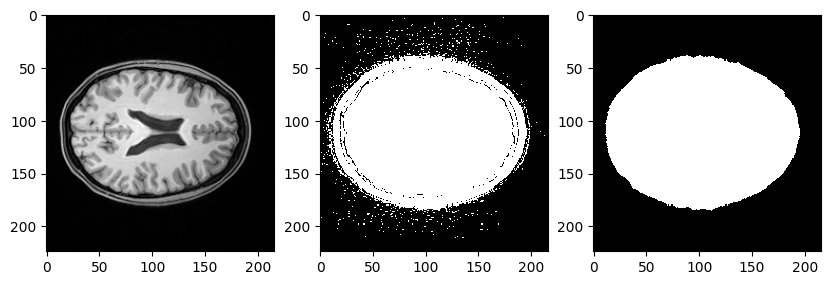

In [108]:
mask_init = ImgT1 > 10
mask = opening(mask_init, disk(2))
mask = closing(mask, disk(3))

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 10))
axs[0].imshow(ImgT1, cmap = 'gray')
axs[1].imshow(mask_init, cmap = 'gray', interpolation = 'none')
axs[2].imshow(mask, cmap = 'gray', interpolation = 'none')
plt.show()

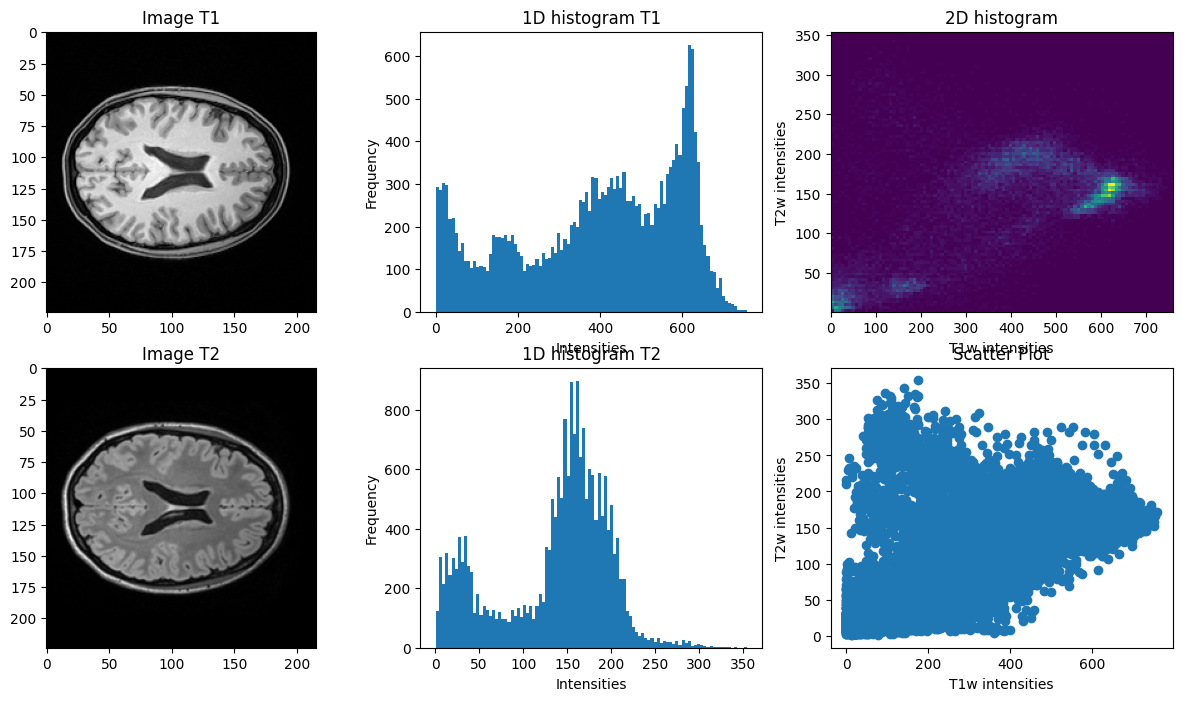

In [109]:
ImgT1_masked = ImgT1[mask]
ImgT2_masked = ImgT2[mask]

fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (15, 8))
axs[0,0].imshow(ImgT1, cmap='gray')
axs[1,0].imshow(ImgT2, cmap = 'gray')
axs[0,1].hist(ImgT1_masked.ravel(), bins=100)
axs[1,1].hist(ImgT2_masked.ravel(), bins=100)
axs[1,2].scatter(ImgT1_masked, ImgT2_masked)
axs[0,2].hist2d(ImgT1_masked, ImgT2_masked, bins=100)

axs[0,1].set_xlabel('Intensities')
axs[0,1].set_ylabel('Frequency')
axs[1,1].set_xlabel('Intensities')
axs[1,1].set_ylabel('Frequency')
axs[0,2].set_xlabel('T1w intensities')
axs[0,2].set_ylabel('T2w intensities')
axs[1,2].set_xlabel('T1w intensities')
axs[1,2].set_ylabel('T2w intensities')

axs[0,0].set_title('Image T1')
axs[1,0].set_title('Image T2')
axs[0,1].set_title('1D histogram T1')
axs[1,1].set_title('1D histogram T2')
axs[1,2].set_title('Scatter Plot')
axs[0,2].set_title('2D histogram')

plt.show()

**Q1**: What is the intensity threshold that can separate the GM and WM classes (roughly) from the 1D histogram? 

- 500 for T1 and 100 for T2

**Q2**: Can the GM and WM intenisty classes be observed in the 2D histogram and scattter plot?
- Yes there appear clear two clusters with maxium intensitised in the 2D histogram that represent the two classes distributions 

### Exercise 2
Place training examples i.e. ROI_WM and ROI_GM into variables C1 and C2 representing class 1 and class 2 respectively. Show in a figure the manually expert drawings of the C1 and C2 training examples.

*Tips*: use `plt.imshow()`

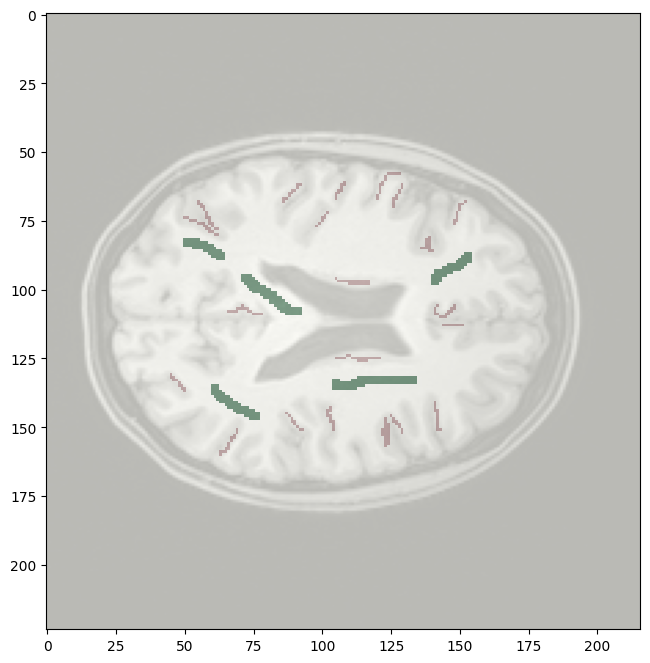

In [110]:
C1 = ROI_WM
C2 = ROI_GM

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))
axs.imshow(ImgT1, cmap = 'gray')
axs.imshow(C2, cmap = 'Reds', alpha = 0.5, interpolation = 'none')
axs.imshow(C1, cmap = 'Greens', alpha = 0.5, interpolation = 'none')
plt.show()

**Q3**: Does the ROI drawings look like what you expect from an expert?

- No, it's only some lines placed on the image

### Exercise 3
For each binary training ROI find the corresponding training examples in ImgT1 and ImgT2. Later these will be extracted for LDA training.

*Tips*: If you are a MATLAB-like programming lover, you may use the `np.argwhere()` function appropriately to return the index to voxels in the image full filling e.g. intensity values >0 hence belong to a given class. Name the index variables qC1 and qC2, respectively.

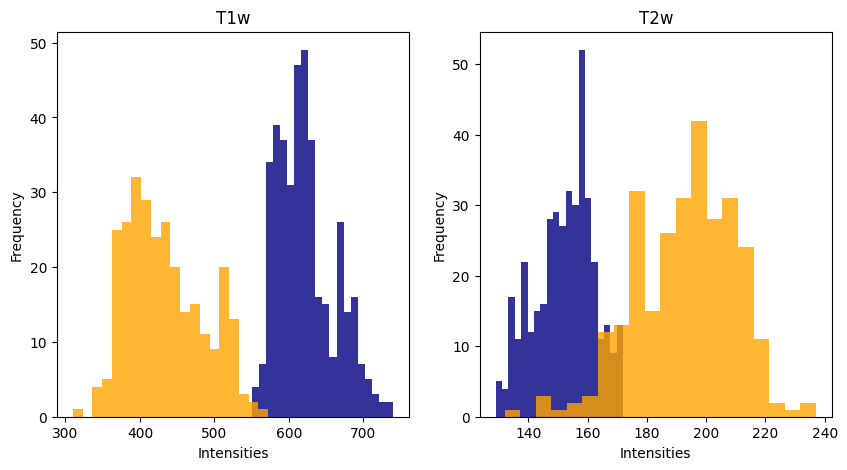

In [111]:
trainWM_T1 = ImgT1[ROI_WM]
trainGM_T1 = ImgT1[ROI_GM]
trainWM_T2 = ImgT2[ROI_WM]
trainGM_T2 = ImgT2[ROI_GM]

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axs[0].hist(trainWM_T1, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[0].hist(trainGM_T1, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[0].set_ylabel('Frequency')
axs[0].set_xlabel('Intensities')
axs[0].set_title('T1w')

axs[1].hist(trainWM_T2, bins=20, color = 'navy', label = 'WM', alpha = 0.8)
axs[1].hist(trainGM_T2, bins=20, color = 'orange', label = 'GM', alpha = 0.8)
axs[1].set_ylabel('Frequency')
axs[1].set_xlabel('Intensities')
axs[1].set_title('T2w')

plt.show()


**Q4**: What is the difference between the 1D histogram of the training examples and the 1D histogram of the whole image? Is the difference expected?
- The difference is that is easily to recognize the two tipes of tissue with the histogram

### Exercise 4
Make a training data vector (X) and target class vector (T) as input for the LDA() function. T and X should have the same length of data points.

- **X**: Training data vector should first include all data points for class 1 and then the data points for class 2. Data points are the two input features ImgT1, ImgT2.
- **T**: Target class identifier for X where '0'are Class 1 and a '1' is Class 2.

*Tip: Read the documentation of the procided LDA function to understand the expected input dimensions.*


In [112]:
X1 = np.c_[ImgT1[ROI_WM], ImgT2[ROI_WM]] 
X2 = np.c_[ImgT1[ROI_GM], ImgT2[ROI_GM]]
X = np.r_[X1, X2]

# Label vector, T -> Shape: (n_samples)
n_pixels = X.shape[0]
n_wm_pixels = X1.shape[0]
T = np.zeros((n_pixels, 1))
T[n_wm_pixels:] = 1


### Exercise 5
Make a scatter plot of the training points of the two input features for class 1 and class 2 as green and black circles, respectively. Add relevant title and lables to axis.

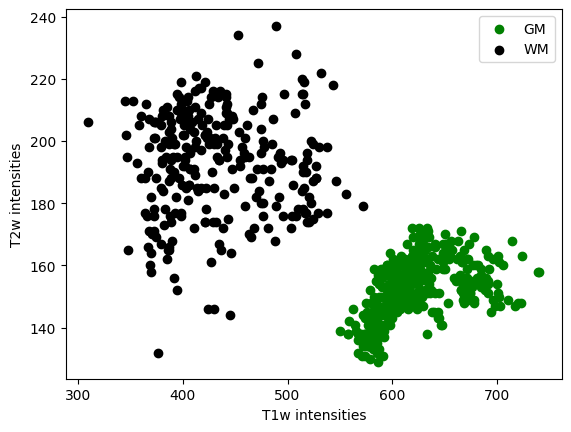

In [113]:
fig, ax = plt.subplots(1,1)
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'GM')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'WM')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
plt.legend()
plt.show()

**Q5**: How does the class separation appear in the 2D scatter plot compared with 1D histofram. Is it better?
- Yes, it works perfectly

### Exercise 6
Train the linear discrimination classifier using the Fisher discriminant function and estimate the weight-vector coefficient W (i.e $w_0$ and $w$) for classification given X and T by using the `W=LDA` function. The LDA function outputs `W=[[w01, w1];[w02, w2]]` for class 1 and 2 respectively.
*Tip: Read the Bishop note on Chapter 4*

In [114]:
W = LDA(X,T)

### Exercise 7
Apply the linear discriminant classifier i.e. perform multi-modal classification using the trained weight-vector $W$ for each class: It calculates the linear score Y for **all** image data points within the brain slice i.e $y(x) = w + w_0$. Actually, $y(x)$ is the $log(P(C_{i}|x))$. 

In [118]:
Xall= np.c_[ImgT1[mask].flatten(), ImgT2[mask].flatten()]
Y = np.c_[np.ones((len(Xall), 1)), Xall] @ W.T

### Exercise 8 
Perform multi-modal classification: Calculate the posterior probability i.e. $P(X|C_1)$ of a data point belonging to class 1.

*Note: Using Bayes [Eq 1]: Since $y(x)$ is the log of the posterior probability [Eq 2] we take $exp(y(x))$ to get $P(X|C_1) = P(X|\mu, \sigma)P(C_1)$ and divide with the marginal probability P(X) as normalisation factor.*


In [119]:
PosteriorProb = np.clip(np.exp(Y) / np.sum(np.exp(Y),1)[:, np.newaxis], 0, 1)

### Exercise 9
Apply segmentation: Find all voxles in the T1w and T2w image with $P(X|C_1)>0.5$ as belonging to Class 1. You may use the `np.where()` function. Similary, find all voxels belonging to class 2. 

In [120]:
posteriorC1 = np.zeros(ImgT1.shape)
posteriorC2 = np.zeros(ImgT1.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 > 0.5
mask_GM = posteriorC2 > 0.5

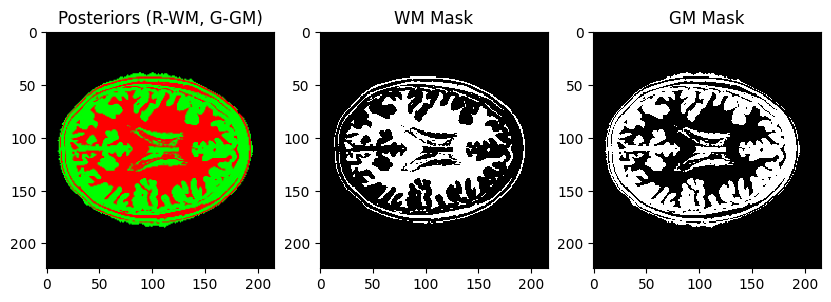

In [121]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
rgb = np.stack((posteriorC1, posteriorC2, np.zeros_like(posteriorC1)), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(mask_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(mask_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

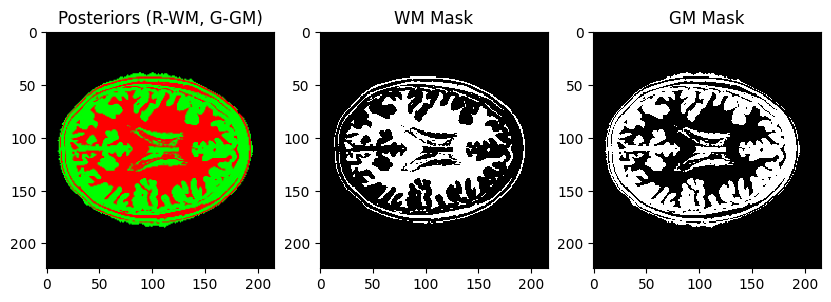

In [122]:
posteriorC1 = np.zeros(ImgT2.shape)
posteriorC2 = np.zeros(ImgT2.shape)

posteriorC1[mask] = PosteriorProb[:,0]
posteriorC2[mask] = PosteriorProb[:,1]
mask_WM = posteriorC1 > 0.5
mask_GM = posteriorC2 > 0.5

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
rgb = np.stack((posteriorC1, posteriorC2, np.zeros_like(posteriorC1)), axis = -1).astype(np.double)
axs[0].imshow(rgb)
axs[0].set_title('Posteriors (R-WM, G-GM)')
axs[1].imshow(mask_WM, cmap = 'gray', interpolation = 'none')
axs[1].set_title('WM Mask')
axs[2].imshow(mask_GM, cmap='gray', interpolation = 'none')
axs[2].set_title('GM Mask')
plt.show()

### Exercise 10
Show scatter plot of segmentation results as in 5.

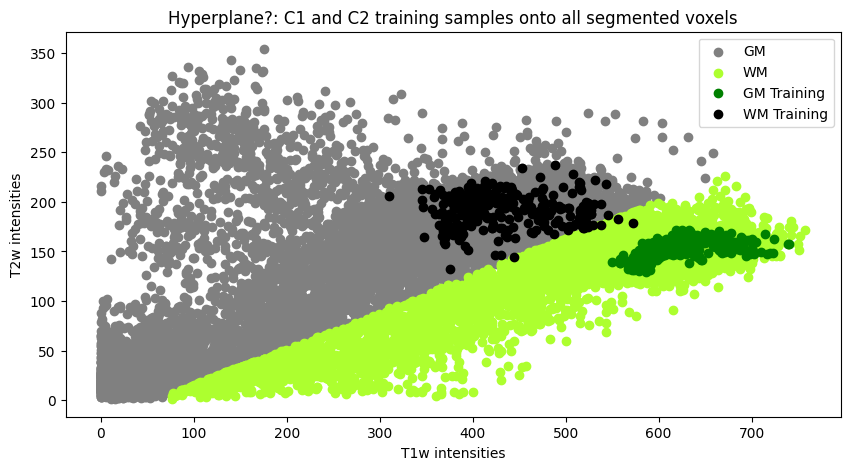

In [123]:
Xall_WM = Xall[PosteriorProb[:,0] > 0.5, :]
Xall_GM = Xall[PosteriorProb[:,1] > 0.5, :]

fig, ax = plt.subplots(1,1, figsize = (10,5))
ax.scatter(Xall_GM[:,0], Xall_GM[:,1], c = 'gray', label = 'GM')
ax.scatter(Xall_WM[:,0], Xall_WM[:,1], c = 'greenyellow', label = 'WM')
ax.scatter(X1[:,0], X1[:,1], c = 'g', label = 'GM Training')
ax.scatter(X2[:,0], X2[:,1], c = 'k', label = 'WM Training')
ax.set_xlabel('T1w intensities')
ax.set_ylabel('T2w intensities')
ax.set_title('Hyperplane?: C1 and C2 training samples onto all segmented voxels')
plt.legend()
plt.show()

**Q6**: Can you identify the hyperplane is placed i.e. y(x)=0?
- Yes, it is easily to identify the hyperplane in all the plot

**Q7** Is the linear hyperplane positioned as you expect or would a non-linear hyper plane perform better?
- Yes and no - I would expect all black and green training data points to be on each side of the hyperplan. Moreover the hyperplan seems to be too linear and there seem to be an extras class at the low image resolutions. 

**Q8**: Would segmentation be as good as using a simple image modality using thresholding?
- If that should be the case the hyperplan would be orthogonal to one of the features. It is not. So no.

**Q9**: From the scatter plot does the segmentation results make sense? Are the two tissue types segmented correctly?
- Looks good, but hard to say from a scatter plot

### Exercise 11
**Q10**: Are the training examples representative for the segmentation results? Are you surprised that so few training examples perform so well? Do you need to be an anatomical expert to draw these?
- Yes they are representative. Yes and no; one do not need to be an anatomical expert, but you need to understand what the method needs as input to perform well.

**Q11**: Compare the segmentation results with the original image. Is the segmentation results satisfactory? Why not?
- Yes, the WM and GM classes looks correct segmented when comparing to the anatomical structures in ImgT1 and ImgT2.

**Q12**: Is one class completely wrong segmented? What is the problem?
- Yes - If you have not masked out the backgroud voxels, all background and skull voxels also are classified as GM. Solution is to identify the background voxels and exclude these from the segmentation or to add an extra class for background/skull voxels. Also the CSF class is segmented as both GM and WM. The segmentation problem is that there are more classes in the image than the classifier has been trained to segment.


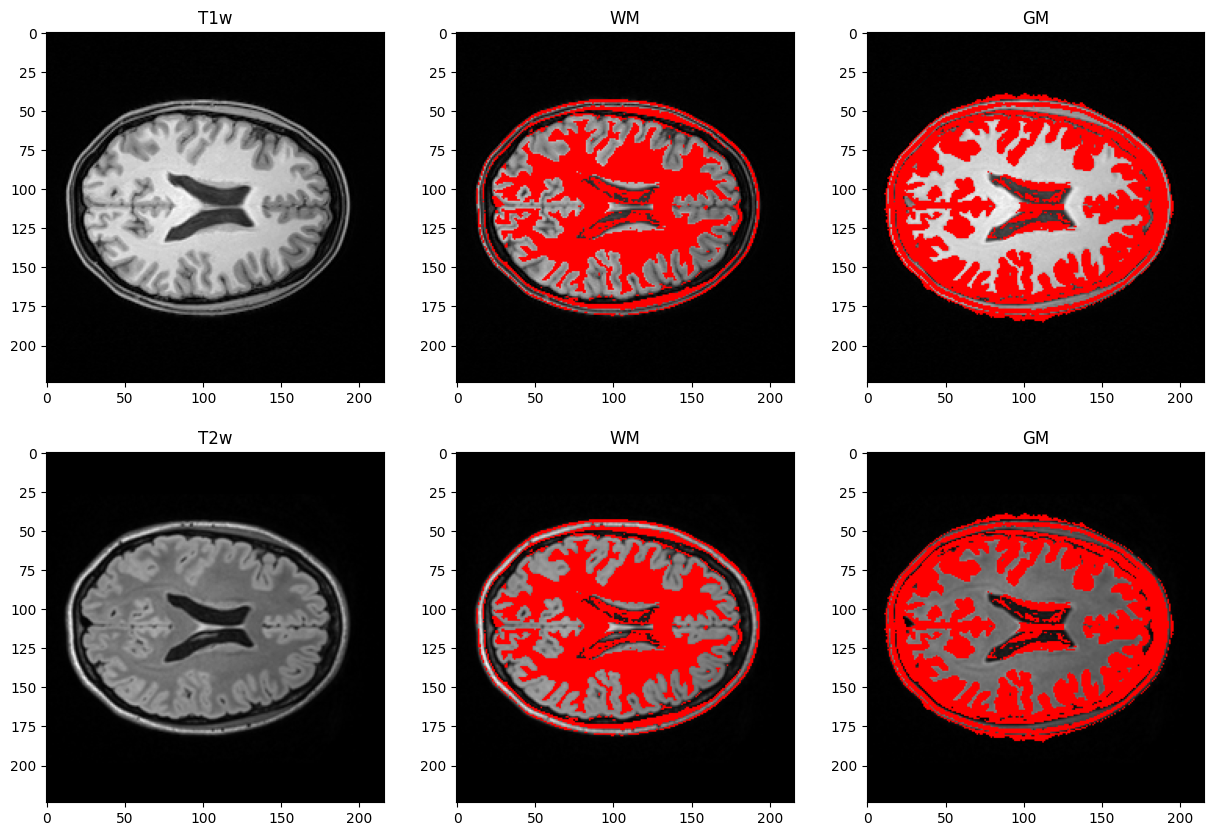

In [124]:
def overlay_segmentation(I, M):
    I = I/I.max()
    I_aux, I_red = I.copy(), I.copy()
    I_aux[M] = 0
    I_red[M] = 1
    tmp = np.stack((I_red, I_aux, I_aux), axis = -1)
    return tmp

tmp = np.zeros(mask_WM.shape)
red_WM = np.stack((mask_WM, tmp, tmp), axis = -1)
green_GM = np.stack((tmp, mask_GM, tmp), axis = -1)

fig, axs = plt.subplots(2, 3, figsize = (15, 10))
axs[0,0].imshow(ImgT1, cmap = 'gray')
axs[0,0].set_title('T1w')
axs[0,1].imshow(overlay_segmentation(ImgT1, mask_WM))
axs[0,1].set_title('WM')
axs[0,2].imshow(overlay_segmentation(ImgT1, mask_GM))
axs[0,2].set_title('GM')

axs[1,0].imshow(ImgT2, cmap = 'gray')
axs[1,0].set_title('T2w')
axs[1,1].imshow(overlay_segmentation(ImgT2, mask_WM))
axs[1,1].set_title('WM')
axs[1,2].imshow(overlay_segmentation(ImgT2, mask_GM))
axs[1,2].set_title('GM')

plt.show()